## Gender Recognition using ANN

In [ ]:
# Install NumPy
%pip install numpy

# Install Pandas
%pip install pandas

# Install tqdm for progress bars
%pip install tqdm

# Install TensorFlow for deep learning models
%pip install tensorflow

# Install Librosa for audio analysis
%pip install librosa

# Install SciPy for scientific computing
%pip install scipy

# Install PyDub for audio file manipulation
%pip install pydub

# Install Matplotlib for plotting
%pip install matplotlib

# Install scikit-learn for machine learning tools
%pip install scikit-learn


In [20]:
import numpy as np 
import scipy
import pandas as pd 
import csv
import os
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tqdm import tqdm

import glob
import shutil
from pydub import AudioSegment
import librosa



### First try to get features : doesn't work, gives always [0]*21

In [21]:
def getFeatures(x):
    try :
        freqs = np.fft.fftfreq(x.size)
        mean = np.mean(freqs)
        std = np.std(freqs)
        median=np.median(freqs)
        maxv = np.amax(freqs)
        minv = np.amin(freqs)
        median = np.median(freqs)
        skew = scipy.stats.skew(freqs)
        kurt = scipy.stats.kurtosis(freqs)
        q1 = np.quantile(freqs, 0.25)
        q3 = np.quantile(freqs, 0.75)
        mode = scipy.stats.mode(freqs)[0][0]
        iqr = scipy.stats.iqr(freqs)
        sp_ent = -np.sum(librosa.feature.spectral_flatness(y=x) * np.log(librosa.feature.spectral_flatness(y=x)))
        sfm = np.mean(librosa.feature.spectral_flatness(y=x))
        centroid  = np.mean(librosa.feature.spectral_centroid(y=x, sr=sr))
        f0_series = librosa.yin(x, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        meanfun = np.mean(f0_series)
        minfun = np.min(f0_series)
        maxfun = np.max(f0_series)
        x_fft = np.fft.fft(x)
        magnitude = np.abs(x_fft)
        meandom = freqs[np.argmax(magnitude)]
        positive_frequencies = freqs[freqs > 0]
        mindom = positive_frequencies[np.argmin(magnitude[freqs > 0])]
        maxdom = positive_frequencies[np.argmax(magnitude[freqs > 0])]
        dfrange = maxdom - mindom
        # Extract F0 using PYIN
        f0, voiced_flag, voiced_probs = librosa.pyin(x, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

        # Delete NaNs
        f0 = f0[~np.isnan(f0)]

        diffs = np.diff(f0)

        # L'indice de modulation
        modindx = np.mean(np.abs(diffs)) / (np.max(f0) - np.min(f0))


        return [mean, std, maxv, minv, median, skew, kurt, q1, q3, mode, iqr, median, sfm, centroid, maxdom, maxfun, meanfun, meandom, mindom, minfun, dfrange, modindx, sp_ent]
    except: return [0]

def GetFeatures(data):
    features = []
    # Define the fields that will be used as column headers in the CSV file
    fields = ['mean', 'std', 'maxv', 'minv', 'median', 'skew', 'kurt', 'q1', 'q3', 'mode', 'iqr', 'median', 'sfm', 'centroid', 'maxdom', 'maxfun', 'meanfun', 'meandom', 'mindom', 'minfun', 'dfrange', 'modindx', 'sp_ent']

    for audio in data :
        features.append(getFeatures(audio))

    with open('DataFeatures.csv', 'w') as f:

        csv_writer = csv.writer(f)

        # Write the field names (column headers) to the first row of the CSV file
        csv_writer.writerow(fields)

        # Write all of the rows of data to the CSV file
        csv_writer.writerows(features)
    return f

## Second try using Mel spectrogram Frequency, MFCC, Chroma, Contrast and Tonnetz

### Extract feature with Librosa : Spoiler alert : didn't work because librosa doesn't load correctly mp3 files

In [24]:
def extract_feature2(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.load(file_name, sr=None)
    
    # Load the MP3 file
    audio = AudioSegment.from_mp3(file_name)

    # Convert to waveform array
    X = np.array(audio.get_array_of_samples())

    # Time values
    framerate = audio.frame_rate
    time = np.linspace(start=0, stop=len(audio) / framerate, num=len(audio))
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
        result = np.hstack((result, mfcc))

    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result


### Trying to plot the waveform using Librosa

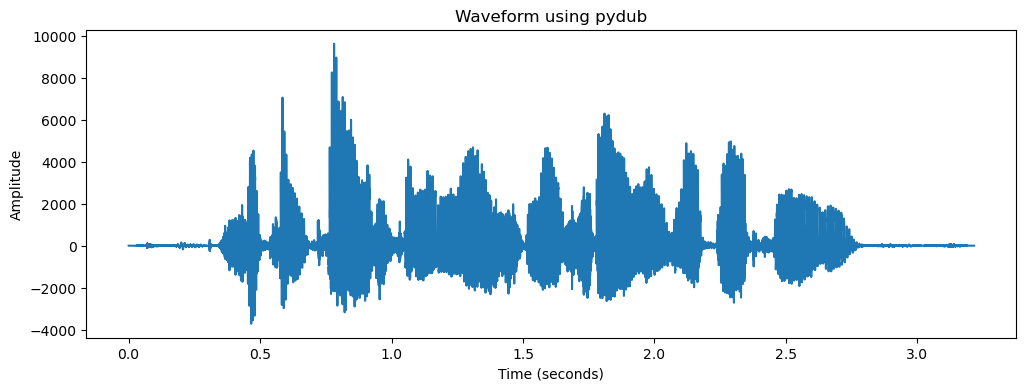

Le fichier audio est vide.
Une erreur est survenue lors du chargement du fichier audio: Input is too short (n=0) for frame_length=1


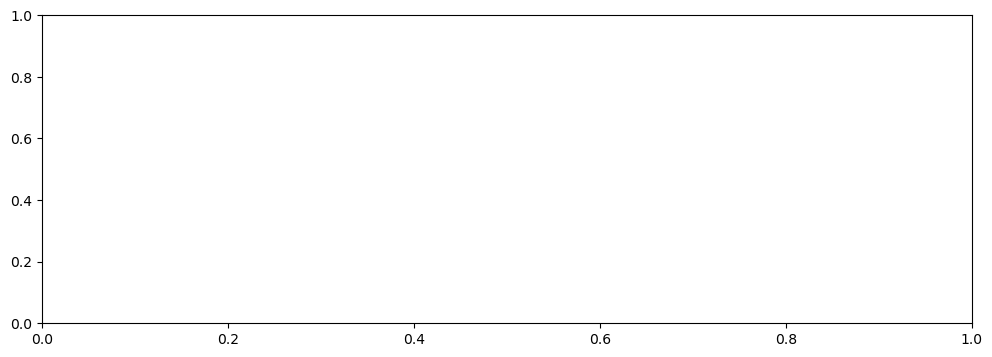

In [23]:
file_path="/Users/mac/Desktop/archive/cv-other-dev/cv-other-dev/sample-000000.mp3"
# Load the MP3 file
audio = AudioSegment.from_mp3(file_path)

# Convert to waveform array
signal = np.array(audio.get_array_of_samples())

# Convert to waveform array
X = np.array(audio.get_array_of_samples())



# Time values
framerate = audio.frame_rate
time = np.linspace(start=0, stop=len(signal) / framerate, num=len(signal))

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time, signal)
plt.title('Waveform using pydub')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.show()
try:
        y, sr = librosa.load(file_path, sr=None) 

        if y.size == 0:
            print("Le fichier audio est vide.")


        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title('Waveform of Audio')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.show()


except Exception as e:
        print(f"Une erreur est survenue lors du chargement du fichier audio: {e}")


## Using Pydub.AudioSegment : It works

In [17]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")

    # Load the audio file with pydub
    audio = AudioSegment.from_file(file_name)
    sample_rate = audio.frame_rate

    # Convert to NumPy array
    audio_data = np.array(audio.get_array_of_samples())
    if audio.channels == 2:  # Check if stereo and convert to mono
        audio_data = audio_data.reshape((-1, 2))
        audio_data = audio_data.mean(axis=1)
    audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max  # Normalize

    # Feature extraction
    result = np.array([])
    if chroma or contrast or tonnetz:
        stft = np.abs(librosa.stft(audio_data))
    
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13).T, axis=0)
        result = np.hstack((result, mfccs))

    if chroma:
        chroma_feature = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_feature))

    if mel:
        mel_feature = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel_feature))

    if contrast:
        contrast_feature = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, contrast_feature))

    if tonnetz:
        tonnetz_feature = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sample_rate).T, axis=0)
        result = np.hstack((result, tonnetz_feature))

    return result


### Once we have a good Balanced_data.csv containing paths to the audios.mp3 + their labels, saved in a folder named Data, we extract their features

### Loading the data, spliting into train-test-validation, defining the Model

In [18]:

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("/Users/mac/Desktop/data/data/Balanced_data.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 0])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 1])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):

        features = extract_feature("/Users/mac/Desktop/archive/cv-other-train/"+filename,  mel = True)
        X[i] = features
        y[i] = gender

    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y


def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }


def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model, but why not."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [25]:

# load the dataset
X, y = load_data()
print(X)
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)
# construct the model
model = create_model()

# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100

# train the model using the training set and validating using validation set
model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])


# save the model to a file
model.save("results/model.h5")

# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Total samples: 23183
Total male samples: 11599
Total female samples: 11584


Loading data: 100%|██████████| 23183/23183 [1:46:00<00:00,  3.65it/s]  


[[7.14310864e-03 1.61338057e-02 2.30557639e-02 ... 2.54096366e-09
  2.48413712e-09 2.43777998e-09]
 [6.23296248e-03 2.46039266e-03 5.73755614e-03 ... 2.53370858e-09
  2.49579712e-09 2.53083354e-09]
 [9.16805002e-04 2.04855460e-03 1.92967569e-03 ... 2.49615750e-09
  2.46899279e-09 2.52861510e-09]
 ...
 [8.76070652e-03 1.24021536e-02 2.79637665e-01 ... 2.58005972e-09
  2.63226174e-09 2.61906941e-09]
 [1.70558915e-01 4.28008175e+00 1.27596388e+01 ... 2.52021515e-09
  2.64013122e-09 2.65393796e-09]
 [7.96847194e-02 1.80307794e+00 1.50008879e+01 ... 2.42274423e-09
  2.47013765e-09 2.49715715e-09]]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                

## Prediction

In [28]:
from tensorflow.keras.models import load_model

def preprocess_audio(file_path):
    # Extract the same features as you did for training
    features = extract_feature(file_path, mel=True)
    return features

def predict_gender(file_path, model):
    # Preprocess the file
    features = preprocess_audio(file_path)
    # Reshape features to match the input shape of the model
    features = np.reshape(features, (1, -1))
    # Make a prediction
    prediction = model.predict(features)[0]
    # Interpret the result
    if prediction <= 0.5:
        return "Female",prediction
    else:
        return "Male",prediction

# Load the model
model = load_model("results/model.h5")

# Path to the new audio file
file_path = "/Users/mac/Desktop/archive/cv-invalid/cv-invalid/sample-000008.mp3"

# Predict the gender
gender = predict_gender(file_path, model)
print(f"The predicted gender is: {gender}")

1/1 [==============================] - 0s 112ms/step
The predicted gender is: ('Female', array([0.11993886], dtype=float32))
